# Basis-Update and Galerkin (BUG) rank-adaptive integration of a tree tensor network state

This notebook performs a Basis-Update and Galerkin (BUG) rank-adaptive integration of a tree tensor network state. The implementation in `chemtensor` is based on the publication:

Gianluca Ceruti, Christian Lubich, Dominik Sulz  
Rank-adaptive time integration of tree tensor networks  
[SIAM J. Numer. Anal. 61, 194-222 (2023)](https://doi.org/10.1137/22M1473790) ([arXiv:2201.10291](https://arxiv.org/abs/2201.10291))

In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import chemtensor

In [2]:
# maximum number of OpenMP threads (0 indicates that OpenMP is not available)
chemtensor.get_max_openmp_threads()

16

### Construct a Hamiltonian as TTNO from a list of operator chains

In [3]:
# number of physical lattice sites
nsites_physical = 6

In [4]:
# physical quantum numbers at each site
qsite = [1, 0, -1]

In [5]:
# local operators
sp = np.array([[0., 1., 0.], [0., 0., 1.], [0., 0., 0.]])
sm = np.array([[0., 0., 0.], [1., 0., 0.], [0., 1., 0.]])
sz = np.diag([ 1.,  0., -1.])
nb = np.diag([ 1.,  0.,  1.])

# operator map; the operator identifiers (OIDs) are the indices for this lookup-table
opmap = [np.identity(3), sp, sm, sz, nb]

In [6]:
def crandn(size=None, rng: np.random.Generator=None):
    """
    Draw random samples from the standard complex normal (Gaussian) distribution.
    """
    if rng is None:
        rng = np.random.default_rng()
    # 1/sqrt(2) is a normalization factor
    return (rng.normal(size=size) + 1j*rng.normal(size=size)) / np.sqrt(2)

In [7]:
rng = np.random.default_rng(42)

# random kinetic coefficients
tkin = crandn(size=nsites_physical-1, rng=rng)

# random interaction coefficients
vint = list(rng.standard_normal(5))

# coefficient map; first two entries must always be 0 and 1;
# the coefficient identifiers (CIDs) are the indices for this lookup-table
coeffmap = [0, 1] + [c if orig else c.conj() for c in tkin for orig in [True, False]] + vint

In [8]:
# operator chains, containing operator identifiers (OIDs) and coefficient identifiers (CIDs)
# referencing 'opmap' and 'coeffmap', respectively
chains = (
    [chemtensor.OpChain([1, 2], [0,  1, 0], 2 + 2*i,     istart=i) for i in range(nsites_physical - 1)] +
    [chemtensor.OpChain([2, 1], [0, -1, 0], 2 + 2*i + 1, istart=i) for i in range(nsites_physical - 1)] +
    [chemtensor.OpChain(rng.choice([0, 3, 4], size=4), [0, 0, 0, 0, 0],
                        2 + 2*len(tkin) + i,
                        istart=rng.integers(0, nsites_physical - 3)) for i in range(len(vint))])

In general, the integer quantum numbers are interleaved with the local operators to implement abelian symmetries (like particle number conservation). In practice, the quantum numbers endow the TTNO tensors with a sparsity pattern, handled internally by `chemtensor`.

To construct the TTNO, we need to define its tree topology.

In [9]:
# tree topology:
#
#     ╭──── 7 ────╮
#    ╱      │      ╲
#   ╱       │       ╲
#  0        3        6
#          ╱ ╲      ╱ ╲
#         ╱   ╲    ╱   ╲
#        1     2  4     5
#

tree_neighbors = [
    [7],        # neighbors of site 0
    [3],        # neighbors of site 1
    [3],        # neighbors of site 2
    [1, 2, 7],  # neighbors of site 3
    [6],        # neighbors of site 4
    [6],        # neighbors of site 5
    [4, 5, 7],  # neighbors of site 6
    [0, 3, 6],  # neighbors of site 7
]

Sites 0, ..., 5 are physical sites, and the remaining sites 6, 7 are branching sites (with dummy physical legs of dimension 1).

In [10]:
hamiltonian = chemtensor.construct_ttno_from_opchains("double complex", nsites_physical, tree_neighbors,
                                                      chains, opmap, coeffmap, qsite)

In [11]:
# number of physical sites
hamiltonian.nsites_physical

6

In [12]:
# number of branching sites (in this example, sites 6 and 7)
hamiltonian.nsites_branching

2

In [13]:
# show virtual bond dimension between sites 3 and 7
hamiltonian.bond_dim(3, 7)

9

In [14]:
# show virtual bond dimension between sites 5 and 6
hamiltonian.bond_dim(5, 6)

5

In [15]:
# overall matrix representation of the TTNO
hamiltonian_mat = hamiltonian.to_matrix()
hamiltonian_mat.shape

(729, 729)

In [16]:
# check Hermitian symmetry
np.linalg.norm(hamiltonian_mat.conj().T - hamiltonian_mat)

0.0

### Construct a random initial TTNS

In [17]:
# quantum numbers for all sites (physical and branching)
qsites = hamiltonian.nsites_physical * (qsite,) + hamiltonian.nsites_branching * ([0],)

In [18]:
# logical overall quantum number sector of the state
qnum_sector = 2

In [19]:
state = chemtensor.construct_random_ttns("double complex", nsites_physical, tree_neighbors,
                                         qsites, qnum_sector, max_vdim=80, rng_seed=42, normalize=True)

In [20]:
# maximum virtual bond dimension
state.max_bond_dim

27

In [21]:
# show virtual bond dimension between sites 3 and 7
state.bond_dim(3, 7)

27

In [22]:
# show virtual bond dimension between sites 0 and 7
state.bond_dim(0, 7)

3

In [23]:
# initial state as vector
state_init_vec = state.to_statevector()

In [24]:
# should be normalized
np.linalg.norm(state_init_vec)

0.9999999999999999

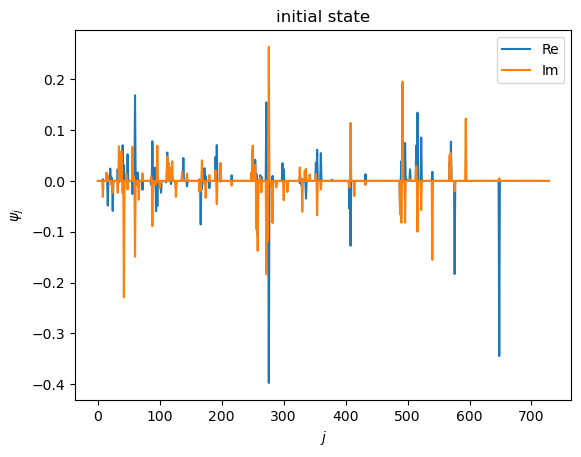

In [25]:
# visualize initial state
plt.plot(state_init_vec.real, label="Re")
plt.plot(state_init_vec.imag, label="Im")
plt.xlabel(r"$j$")
plt.ylabel(r"$\psi_j$")
plt.title("initial state")
plt.legend()
plt.show()

### Perform BUG time integration

The BUG integrator updates the `state` in-place.

In [26]:
# integration prefactor
prefactor = -0.1 - 0.8j
# time step
dt = 0.1
# number of time steps
nsteps = 5
# designated root node
i_root = 7

for i in range(nsteps):
    chemtensor.bug_tree_time_step(state, hamiltonian, i_root, prefactor, dt, rel_tol_compress=1e-2)

In [27]:
# quantum number sector remains unchanged
state.quantum_number_sector

2

In [28]:
# maximum bond dimension after time integration
state.max_bond_dim

14

In [29]:
# state vector after integration
state_vec = state.to_statevector()

In [30]:
# state is not normalized due to complex integration prefactor
np.linalg.norm(state_vec)

0.9851658533730621

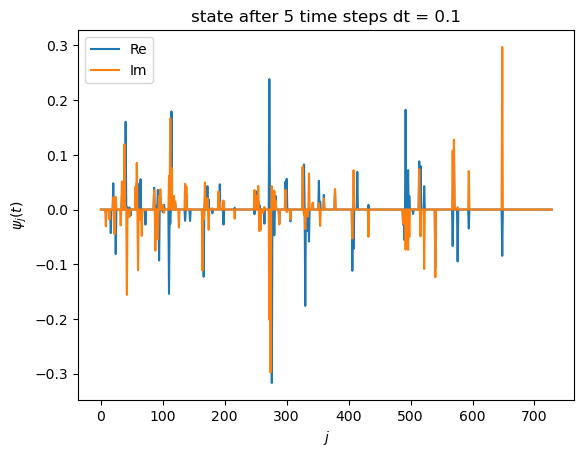

In [31]:
# visualize time-evolved state
plt.plot(state_vec.real, label="Re")
plt.plot(state_vec.imag, label="Im")
plt.xlabel(r"$j$")
plt.ylabel(r"$\psi_j(t)$")
plt.title(f"state after {nsteps} time steps dt = {dt}")
plt.legend()
plt.show()

In [32]:
# reference solution
tmax = nsteps*dt  # overall simulation time
state_ref = expm(prefactor * tmax * hamiltonian_mat) @ state_init_vec

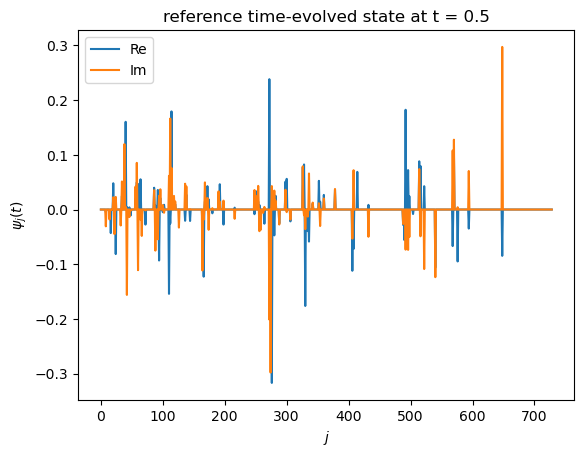

In [33]:
# visualize reference solution
plt.plot(state_ref.real, label="Re")
plt.plot(state_ref.imag, label="Im")
plt.xlabel(r"$j$")
plt.ylabel(r"$\psi_j(t)$")
plt.title(f"reference time-evolved state at t = {tmax}")
plt.legend()
plt.show()

In [34]:
print("BUG integration error:",  np.linalg.norm(state_vec - state_ref))

BUG integration error: 9.827381973754304e-05
